# Modeling catalytic combustion om methane using RMG-Cat
Based somewhat on the notebook to accompany the manuscript: <br/>
*"Automatic generation of microkinetic mechanisms for heterogeneous catalysis"* by<br/>
C. Franklin Goldsmith, School of Engineering, Brown University, franklin_goldsmith@brown.edu, and<br/>
Richard H. West, Department of Chemical Engineering, Northeastern University, r.west@northeastern.edu

As modified to prepare data for the AIChE conference presentation:
304c Incorporation of Linear Scaling Relations into Automatic Mechanism Generation for Heterogeneous Catalysis
Richard H. West, Department of Chemical Engineering, Northeastern University, Boston, MA and C. Franklin Goldsmith, Engineering, Brown University, Providence, RI
Tuesday, October 31, 2017
https://aiche.confex.com/aiche/2017/meetingapp.cgi/Paper/500172
https://www.slideshare.net/richardhwest/incorporation-of-linear-scaling-relations-into-automatic-mechanism-generation-for-heterogeneous-catalysis

Then further updated to model catalytic combustion of methanol.

First, we print what git commit we were on when we ran this notebook, for both the source code (RMG-Py) and the database. 

In [1]:
%%bash
export RMGpy=~/Code/RMG-Py
pwd
git log -n1 --pretty=oneline
cd ../RMG-Py
pwd
git log -n1 --pretty=oneline
cd ../RMG-database
pwd
git log -n1 --pretty=oneline

/Users/emilymazeau/Code/linear-scaling-tests
7eba4f65b6db619f26dec17ee8e6cadef9e24f04 trying again
/Users/emilymazeau/Code/RMG-Py
474969c03bd48274a2af7d1a9b1bbed74ed46e85 Add 'X' to adsorbate names taken from gas phase thermo libraries.
/Users/emilymazeau/Code/RMG-database
48e0a55a7d3f8270c5ffe2dc78f850ed50f7f4f2 Merge remote-tracking branch 'official/master' into cat, again


## Model generation
We start with a base input file to generate a mechanism for CH3OH plus O2.
First we print the input file we'll use to generate the model.

In [2]:
%cat base/input.py

# Data sources
database(
    thermoLibraries=['surfaceThermo', 'primaryThermoLibrary', 'thermo_DFT_CCSDTF12_BAC','DFT_QCI_thermo'],
    reactionLibraries = [('Deutschmann_Ni', False)],
    seedMechanisms = [],
    kineticsDepositories = ['training'],
    kineticsFamilies = 'default',
    kineticsEstimator = 'rate rules',
    bindingEnergies = { # default values for Ni(111)
                       'C':(-5.997, 'eV/molecule'),
                       'H':(-2.778, 'eV/molecule'),
                       'O':(-4.485, 'eV/molecule'),
                       }
)

# List of species
species(
    label='X',
    reactive=True,
    structure=adjacencyList("1 X u0"),
)

species(
    label='CH4',
    reactive=True,
    structure=SMILES("[CH4]"),
)
species(
   label='O2',
   reactive=True,
   structure=adjacencyList(
       """
1 O u1 p2 c0 {2,S}
2 O u1 p2 c0 {1,S}
"""),
)

species(
    label='N2',
    reactive=False,
    structure=SMILES("N#N"),
)

species(
    label='CO2',
    reactive=True,
    struc

Then we try running it. This will take Richard's computer about four minutes and Emily's computer 25 minutes.

In [3]:
%%bash
python ~/Code/RMG-Py/rmg.py base/input.py > /dev/null
tail -n12 base/RMG.log

    Execution time (DD:HH:MM:SS): 00:00:23:43
    Memory used: 1050.95 MB

Making seed mechanism...
Performing final model checks...

MODEL GENERATION COMPLETED

The final model core has 101 species and 324 reactions
The final model edge has 1088 species and 2975 reactions

RMG execution terminated at Mon Jul  9 15:32:04 2018


:root:Removing old /Users/emilymazeau/Code/linear-scaling-tests/base/RMG_backup.log
:root:Moving /Users/emilymazeau/Code/linear-scaling-tests/base/RMG.log to /Users/emilymazeau/Code/linear-scaling-tests/base/RMG_backup.log

/Users/emilymazeau/Code/RMG-Py/rmgpy/data/kinetics/family.py:1135: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  data = item.generateReverseRateCoefficient()
/Users/emilymazeau/Code/RMG-Py/rmgpy/thermo/thermoengine.py:58: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  wilhoit = thermo0.toWilhoit(B=10

There are 70 species and 218 reactions (?)

## Data processing
Next we will import some libraries and set things up to start importing and analyzing the simulation results.

In [4]:
%config InlineBackend.figure_format = 'retina'

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib

# The default output Type 3 (Type3) fonts can't be edited in Adobe Illustrator
# but Type 42 (TrueType) fonts can be, making it easier to move labels around
# slightly to improve layout before publication.
matplotlib.rcParams['pdf.fonttype'] = 42 

# Seaborn helps make matplotlib graphics nicer
import seaborn as sns
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.0})

import os
import re
import pandas as pd
import numpy as np
import shutil
import subprocess
import multiprocessing

In [6]:
def get_last_csv_file(job_directory):
    """
    Find the CSV file from the largest model in the provided job directory.
    
    For CSV files named `simulation_1_13.csv` you want 13 to be the highest number.
    """
    solver_directory = os.path.join(job_directory,'solver')
    csv_files = sorted([f for f in os.listdir(solver_directory) if f.endswith('.csv') ],
                       key=lambda f: int(f[:-4].split('_')[2]))
    return os.path.join(solver_directory, csv_files[-1])
    
job_directory = 'base'
get_last_csv_file(job_directory)

'base/solver/simulation_1_101.csv'

We will use Pandas to import the csv file

In [7]:
last_csv_file = get_last_csv_file(job_directory)
data = pd.read_csv(last_csv_file)
data

,Time (s),Volume (m^3),N2,Ar,He,Ne,X(1),CH4(2),O2(3),CO2(4),...,SX(943),SX(974),C2H3X(50),SX(617),C3H8X(43),C3H7X(41),SX(254),C3H7X(42),SX(169),C3H7(62)
0,0.000000e+00,0.098469,0.705882,0.0,0.0,0.0,0.285560,0.000000e+00,1.764706e-01,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,1.856202e-23,0.098469,0.705882,0.0,0.0,0.0,0.285560,4.717598e-50,1.764706e-01,1.680474e-101,...,1.815842e-157,-9.103578e-194,2.978876e-81,5.589589e-89,-8.244069e-106,-7.465910e-108,-1.239111e-158,-2.488637e-108,-1.757593e-143,-1.956214e-116
2,5.197367e-23,0.098469,0.705882,0.0,0.0,0.0,0.285560,7.129194e-49,1.764706e-01,1.856996e-99,...,5.575303e-155,1.005338e-190,6.663628e-80,2.893332e-87,1.383778e-104,1.253163e-106,3.173318e-156,4.177209e-107,3.571228e-141,3.283537e-115
3,1.187970e-22,0.098469,0.705882,0.0,0.0,0.0,0.285560,7.669248e-48,1.764706e-01,1.680071e-97,...,5.325582e-152,4.394961e-187,1.316621e-78,1.263342e-85,1.631208e-102,1.477238e-104,3.592568e-153,4.924127e-105,1.980076e-138,3.870682e-113
4,2.524435e-22,0.098469,0.705882,0.0,0.0,0.0,0.285560,7.049355e-47,1.764706e-01,1.271504e-95,...,3.638884e-149,1.276425e-183,2.342857e-77,4.703106e-84,1.289394e-100,1.167688e-102,2.704337e-150,3.892294e-103,7.259774e-136,3.059627e-111
5,5.197367e-22,0.098469,0.705882,0.0,0.0,0.0,0.285560,6.030870e-46,1.764706e-01,8.833452e-94,...,2.142735e-146,3.095097e-180,3.951573e-76,1.620291e-82,9.125113e-99,8.263791e-101,1.667862e-147,2.754597e-101,2.208166e-133,2.165361e-109
6,1.054323e-21,0.098469,0.705882,0.0,0.0,0.0,0.285560,4.986439e-45,1.764706e-01,5.887460e-92,...,1.175272e-143,6.887802e-177,6.490479e-75,5.377156e-81,6.135928e-97,5.556756e-99,9.355449e-145,1.852252e-99,6.150769e-131,1.456100e-107
7,2.123496e-21,0.098469,0.705882,0.0,0.0,0.0,0.285560,4.054889e-44,1.764706e-01,3.844737e-90,...,6.226505e-141,1.469950e-173,1.052137e-73,1.752068e-79,4.024417e-95,3.644551e-97,5.011346e-142,1.214850e-97,1.641749e-128,9.551058e-106
8,4.261841e-21,0.098469,0.705882,0.0,0.0,0.0,0.285560,3.270415e-43,1.764706e-01,2.485498e-88,...,3.242679e-138,3.072856e-170,1.694442e-72,5.657321e-78,2.607249e-93,2.361150e-95,2.624126e-139,7.870500e-96,4.291093e-126,6.188796e-104
9,8.538531e-21,0.098469,0.705882,0.0,0.0,0.0,0.285560,2.626975e-42,1.764706e-01,1.598725e-86,...,1.674409e-135,6.357963e-167,2.719981e-71,1.818495e-76,1.678830e-91,1.520365e-93,1.358697e-136,5.067884e-94,1.109958e-123,3.986399e-102


In [8]:
def get_pandas_data(job_directory):
    """
    Get the last CSV file from the provided job directory,
    import it into a Pandas data frame, and tidy it up a bit.
    """
    last_csv_file = get_last_csv_file(job_directory)
    data = pd.read_csv(last_csv_file)
    
    # Make the Time into an index and remove it as a column
    data.index = data['Time (s)']
    del data['Time (s)']
    # Remove inerts that RMG added automatically but we're not using
    for i in 'Ar He Ne'.split():
        del data[i]
    # Remove the Volume column
    del data['Volume (m^3)']
    # Set any amounts that are slightly negative (within the ODE solver's ATOL tolerance), equal to zero
    # to allow 'area' plots without warnings or errors.
    # Anything more negative than -1e-16 probably indicates a bug in RMG and should not be hidden here ;-)
    data[(data<0) & (data>-1e-16)] = 0
    return data

In [9]:
def rename_columns(data):
    """
    Removes the number (##) from the end of the column names, in place,
    unless doing so would make the names collide.
    Also renames a few species so the plot labels match the names in the manuscript.
    """
    import re
    old = data.columns
    new = [re.sub('\(\d+\)$','',n) for n in old]
    # don't translate names that would no longer be unique
    mapping = {k:v for k,v in zip(old,new) if new.count(v)==1}
    data.rename(columns=mapping, inplace=True)
    
    # Now change a few species that are named differently in the manuscript
    # than in the thermodynamics database used to build the model,
    # so that the plot labels match the manuscript.
    mapping = {'COX':'COvdwX', 'OCX': 'CO=X', 'C2H3X':'CH3CX', 'C2H3OX':'CH3CXO'}
    data.rename(columns=mapping, inplace=True)

In [10]:
data1 = get_pandas_data('base')
rename_columns(data1)
data1.columns

Index([u'N2', u'X', u'CH4', u'O2', u'CO2', u'H2O', u'H2', u'CO', u'C2H6',
       u'CH2O', u'CH3', u'C3H8', u'H', u'C2H5', u'CH3OH', u'HCO', u'CH3CHO',
       u'OH', u'C2H4(18)', u'CH3OHX', u'OX', u'HX', u'CH3OX(45)', u'OCCO',
       u'HOX', u'CH2OX(135)', u'CHOX', u'H2X', u'H2OX', u'HO2X', u'SX(156)',
       u'SX(155)', u'CX', u'CO=X', u'COvdwX', u'CH3OX(44)', u'SX(179)',
       u'CH3X', u'CH2X', u'CHX', u'CXHO', u'SX(165)', u'CH4X', u'CO2X',
       u'SX(185)', u'SX(183)', u'SX(246)', u'SX(225)', u'SX(143)', u'CH2OH',
       u'HO2', u'CH2OX(40)', u'HOCXO', u'SX(265)', u'CH3O', u'SX(191)',
       u'SX(333)', u'SX(356)', u'SX(178)', u'HOOH', u'HOOHX', u'CH2(S)',
       u'C2H6O', u'SX(422)', u'C2H4X', u'C2H4(32)', u'CHO4', u'O(T)', u'CH3O3',
       u'DME', u'DMEX', u'C3H6O', u'S(439)', u'C2H4O(412)', u'C2H4O(30)',
       u'C2H4OX', u'C2H4O(139)', u'SX(620)', u'S(411)', u'S(692)', u'S(693)',
       u'C2H6X', u'CH4O2', u'SX(878)', u'SX(171)', u'SX(885)', u'SX(914)',
       u'SX(161)', u'SX(

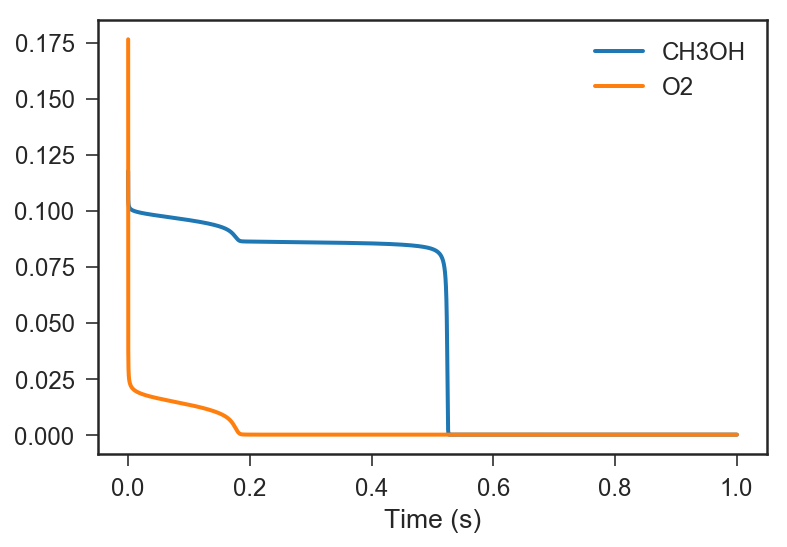

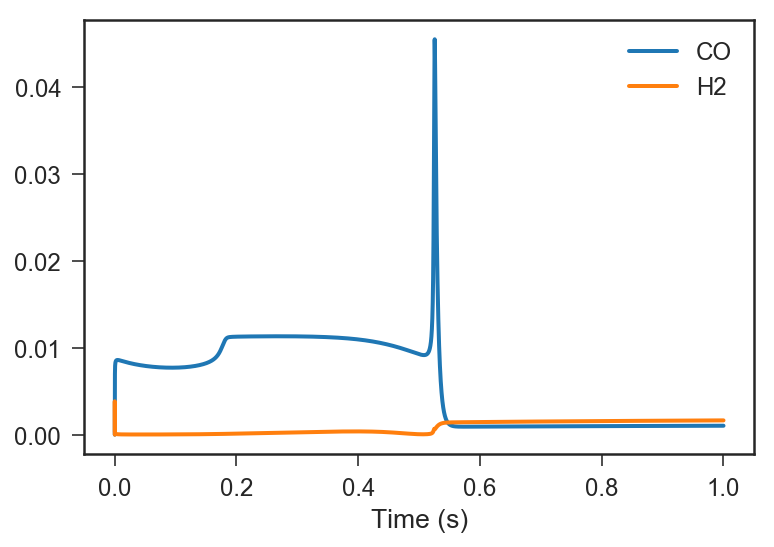

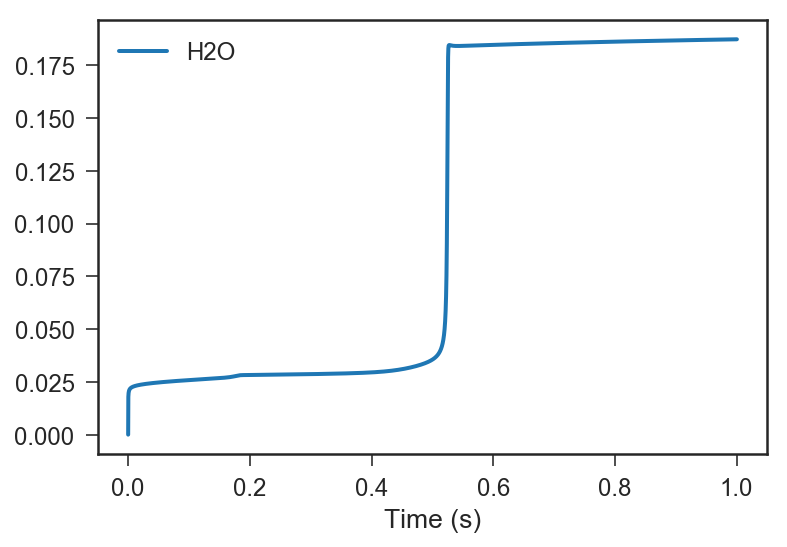

In [11]:
# Test it with some plots
data1[['CH3OH', 'O2']].plot.line()
data1[['CO', 'H2']].plot.line()
data1[['H2O']].plot.line()

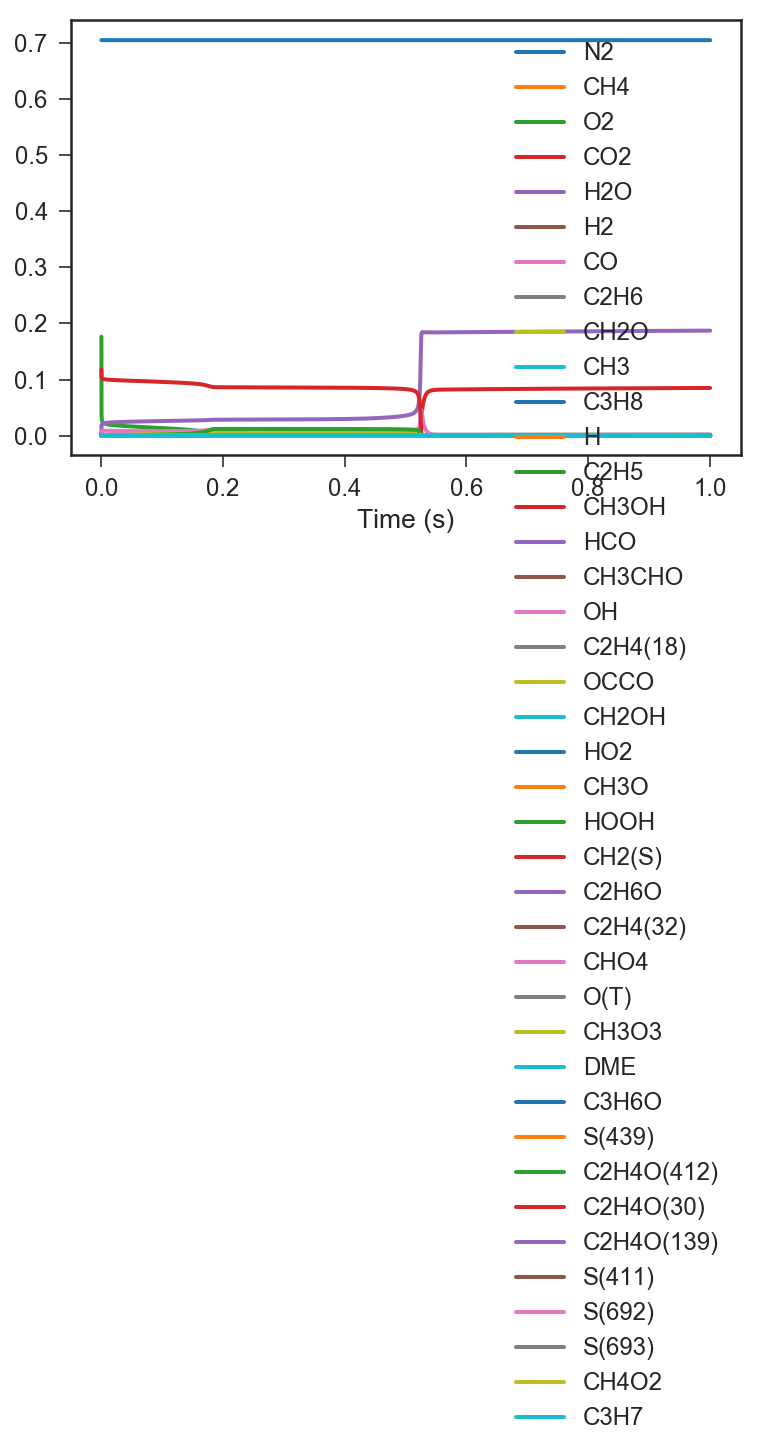

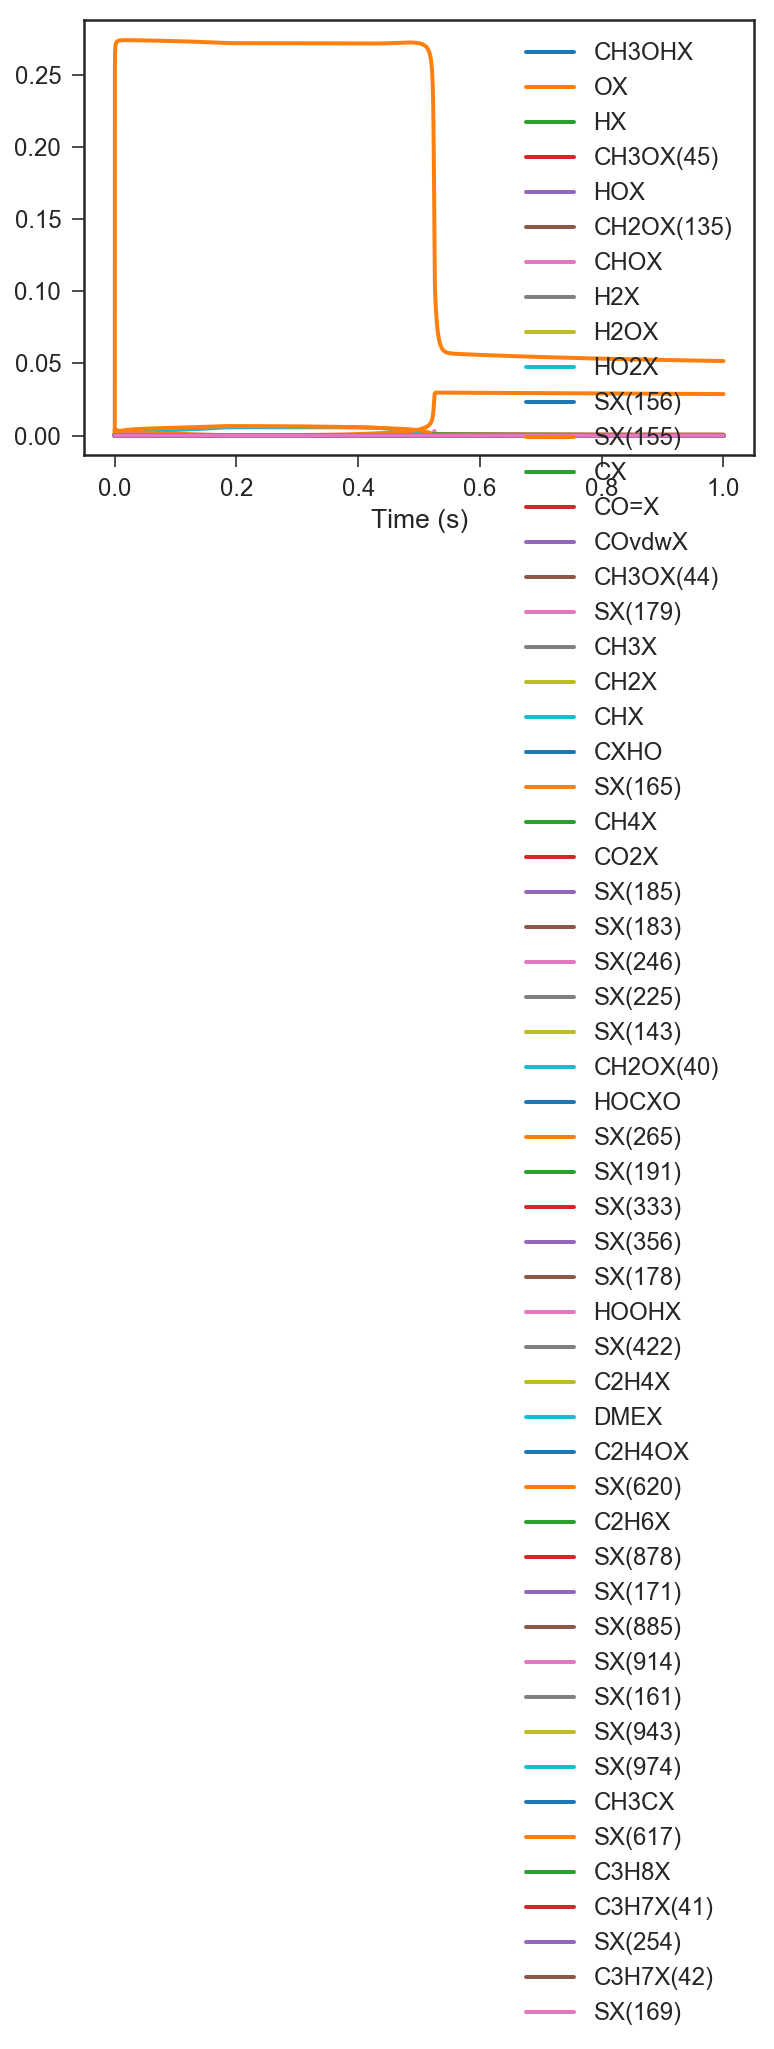

In [12]:
species_names = data1.columns
# just the gas phase species that aren't always zero:
gas_phase = [n for n in species_names if 'X' not in n and (data1[n]>0).any()]
# all the surface species
surface_phase = [n for n in species_names if 'X' in n]
surface_phase.remove('X')
data1[gas_phase].plot.line()
data1[surface_phase].plot.line()

Significant species (those that exceed 0.001 mol at some point)


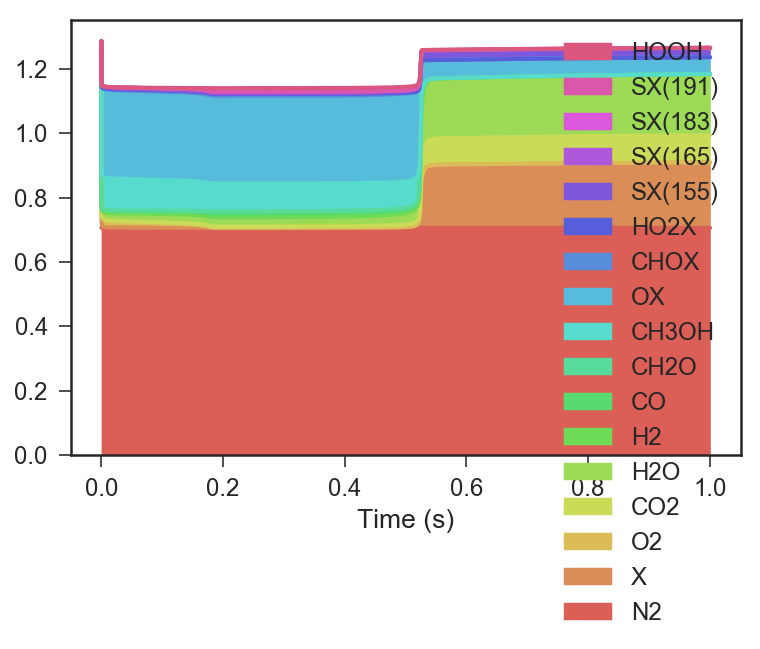

In [13]:
print "Significant species (those that exceed 0.001 mol at some point)"
significant = [n for n in data1.columns if(data1[n]>0.001).any()]
with sns.color_palette("hls", len(significant)):
    data1[significant].plot.area(legend='reverse')

The 14 surface species that exceed 1.0e-04 mol at some point


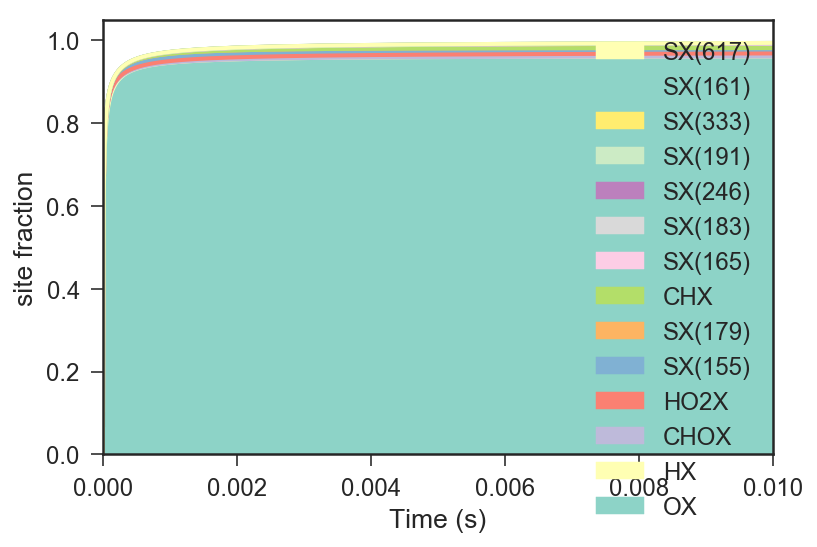

In [14]:
lim = 1e-4
surface = [n for n in data1.columns if 'X' in n and n!='X' and (data1[n]>lim).any() ]
print "The {} surface species that exceed {:.1e} mol at some point".format(len(surface), lim)
total_sites = max(data1['X'])
with sns.color_palette('Set3',len(surface)):
    (data1[surface]/total_sites).plot.area(legend='reverse')
    plt.ylabel('site fraction')
    plt.xlim(0,1e-2) ## notice this is much less than 1 seconde

# Effect of binding energies

Now we will use that template 'base' input file to create a ton of other input files with different binding energies, then run them all in RMG-Cat, then process the results.

In [15]:
# First, make a series of input files in separate directories

with open(os.path.join('base', 'input.py')) as infile:
    input_file = infile.read()
    
base_directory = 'binding_energies'
def directory(carbon,oxygen):
    return os.path.join(base_directory, "c{:.3f}o{:.3f}".format(carbon,oxygen))

def make_input(binding_energies):
    """
    Make an input file for the given (carbon,oxygen) tuple (or iterable) of binding energies
    and return the name of the directory in which it is saved.
    """
    carbon, oxygen = binding_energies
    output = input_file
    out_dir = directory(carbon, oxygen)
    carbon_string = "'C':({:f}, 'eV/molecule')".format(carbon)
    output = re.sub("'C':\(.*?, 'eV/molecule'\)", carbon_string, output)
    oxygen_string = "'O':({:f}, 'eV/molecule')".format(oxygen)
    output = re.sub("'O':\(.*?, 'eV/molecule'\)", oxygen_string, output)
    os.path.exists(out_dir) or os.makedirs(out_dir)
    out_file = os.path.join(out_dir, 'input.py')
    with open(out_file,'w') as outfile:
        outfile.write(output)
    shutil.copy(os.path.join('base','run.sh'), out_dir)
    return out_dir

    
print make_input((-8,-3.5))
    

binding_energies/c-8.000o-3.500


In [17]:
def run_simulation(binding_energies):
    """
    Assuming a job file already exists, run it.  This one is local.
    Takes a tuple of binding energies, (carbon, oxygen)
    """
    carbon, oxygen = binding_energies
    job_directory = directory(carbon, oxygen)
    print job_directory
    assert os.path.exists(job_directory)
    return subprocess.check_call('./run.sh', cwd=job_directory)


In [ ]:
# Revised range
carbon_range = (-7.5, -2)
oxygen_range = (-6.5, -1.5)
grid_size = 9
mesh  = np.mgrid[carbon_range[0]:carbon_range[1]:grid_size*1j, 
                 oxygen_range[0]:oxygen_range[1]:grid_size*1j]

with sns.axes_style("whitegrid"):
    plt.axis('square')
    plt.xlim(carbon_range)
    plt.ylim(oxygen_range)
plt.show()
    
mesh

In [ ]:
experiments = mesh.reshape((2,-1)).T
experiments

In [ ]:
with sns.axes_style("whitegrid"):
    plt.axis('square')
    plt.xlim(carbon_range)
    plt.ylim(oxygen_range)
    plt.plot(*experiments.T, marker='o', linestyle='none')

In [ ]:
map(make_input, experiments)

In [ ]:
# Now run the simulations using a pool.
# Don't run this cell unless you have a while to wait!! ###

#pool = multiprocessing.Pool()
#result = pool.map(run_simulation, experiments)

# Instead, upload the input files to a cluster and run `start_all.sh`
# The script `stage_all.sh` will stage (add) the results in git
# so you can commit and get them back to analyze with the subsequent cells:

In [ ]:
base_directory = 'binding_energies'
# base_directory = 'binding_energies_local'

In [ ]:
def get_data(experiment):
    carbon, oxygen = experiment
    directory(carbon,oxygen)
    try:
        data = get_pandas_data(directory(carbon,oxygen))
    except OSError:
        return None
    rename_columns(data)
    return data

In [ ]:
datas = {tuple(e): get_data(e) for e in experiments}

In [ ]:
def get_max_co2(experiment):
    data = datas[tuple(experiment)]
    if data is None:
        return np.nan
    return data[['CO2']].max()
highest_co2 = max([float(get_max_co2(e)) for e in experiments])

## Fit an exponential
For this first attempt to extract "rate" we fit an exponential growth curve to the normalized CO2 concentration profile of each simulation.
First we plot all the curves on one plot, then we'll plot each with its fitted exponential.

In [ ]:
import seaborn as sns
plt.figure(figsize=(5, 4))
num_lines = len(experiments)
sns.set_palette(sns.color_palette("coolwarm",num_lines))

ax = plt.axes()
def make_label(experiment):
    return "{:+.1f}, {:+.1f}".format(*experiment)

for experiment in experiments:
    #print experiment
    data = get_data(experiment)
    if data is None:
        print("No data for {}".format(experiment))
        continue
    times = np.array(data.index)
    normalized = data[['CO2']].values / highest_co2
    ax.plot(times, normalized, label=make_label(experiment))
    #normalized.plot.line(ax=ax, label=make_label(experiment))
    #ax.text(times[-10], normalized[-10], make_label(experiment))

#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Time (s)')
plt.ylabel('Normalized CO$_2$ concentration')

In [ ]:
sns.set_palette('Set1')

def my_function(time, rate):
    "Thing we want to fit."
    return 1. - np.exp(-1*time*rate)
import scipy.optimize


def fit_rate(data):
    normalized = data[['CO2']] / highest_co2
    x_data = np.array(normalized.index)
    y_data = normalized.values[:,0] 
    
    try:
        popt, pcov = scipy.optimize.curve_fit(my_function, x_data, y_data)
    except RuntimeError as e:
        print("☝️ couldn't fit: {}".format(e.message))
        return np.nan
        
    optimal_parameters = popt
    parameter_errors = np.sqrt(np.diag(pcov))
    print("Rate: {} +/- {} (1 st. dev.)".format(optimal_parameters[0],parameter_errors[0]))

    plt.plot(x_data, y_data, 'o')
    plt.plot(x_data, my_function(x_data, *optimal_parameters))
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized CO$_2$ concentration')
    
    plt.show()
    fitted_rate = optimal_parameters[0]
    return fitted_rate

rates = []
for experiment in experiments:
    print experiment
    data = get_data(experiment)
    if data is None:
        print("☝️No data")
        rates.append(np.nan)
        continue
    rate = fit_rate(data)
    rates.append(rate)

rates
    

In [ ]:
rates = np.array(rates)
fixed_rates = rates * (rates>0) + (1e-9 * (rates<0))
log_rates = np.log(fixed_rates)
log_rates

In [ ]:
rate_grid = np.reshape(log_rates, (grid_size,grid_size))

In [ ]:
ax = sns.heatmap(rate_grid)

In [ ]:
extent = carbon_range + oxygen_range
extent

In [ ]:
# Because the center of a corner pixel is in fact the corner of the grid
# we want to stretch the image a little
c_step = mesh[0,1,0]-mesh[0,0,0]
o_step = mesh[1,0,1]-mesh[1,0,0]
carbon_range2 = (carbon_range[0]-c_step/2, carbon_range[1]+c_step/2)
oxygen_range2 = (oxygen_range[0]-c_step/2, oxygen_range[1]+c_step/2)
extent2 = carbon_range2 + oxygen_range2
extent2

In [ ]:
plt.imshow(rate_grid.T, interpolation='none', origin='lower', extent=extent2, aspect='equal')
plt.plot(-5.997, -4.485, 'ok')
plt.text(-5.997, -4.485, 'Ni(111)')

In [ ]:
# Binding energies extracted from:
u"""
Medford, A. J.; Lausche, A. C.; Abild-Pedersen, F.;
Temel, B.; Schjødt, N. C.; Nørskov, J. K.; Studt, F. 
Activity and Selectivity Trends in 
Synthesis Gas Conversion to Higher Alcohols. 
Topics in Catalysis 2014, 57 (1-4), 135–142 
DOI: 10.1007/s11244-013-0169-0.
"""
medford_energies = { # Carbon, then Oxygen
'Ru': ( 0.010349288486416697, -2.8153856448231256),
'Rh': ( 0.16558861578266493, -2.546620868091181),
'Ni': ( 0.3001293661060802, -2.5881741535441853),
'Ir': ( 0.36222509702457995, -2.826185484230718),
'Pd': ( 0.28460543337645516, -1.207119596734621),
'Pt': ( 0.8796895213454077, -1.445820136503547),
'Cu': ( 2.323415265200518, -1.7218249542757729),
'Ag': ( 3.855109961190168, -0.8341504215550701),
'Au': ( 3.5601552393272975, -0.10963108355266138),
}

In [ ]:
# Shift Medford's energies so that Ni matches Wayne Blaylock's Ni
blaylock_ni = np.array([-5.997, -4.485])
old_ni = np.array(medford_energies['Ni'])
shifted_energies = {metal: tuple(blaylock_ni + np.array(E)-old_ni) for metal,E in medford_energies.items()}
shifted_energies

In [ ]:
plt.imshow(rate_grid.T, interpolation='none', origin='lower', extent=extent2, aspect='equal')
for metal, coords in shifted_energies.iteritems():
    plt.plot(coords[0], coords[1], 'ok')
    plt.text(coords[0], coords[1], metal)
plt.xlim(carbon_range)
plt.ylim(oxygen_range)

In [ ]:
# Binding energies for close packed surfaces from
"""
Abild-Pedersen, F.; Greeley, J.; Studt, F.; Rossmeisl, J.;
Munter, T. R.; Moses, P. G.; Skúlason, E.; Bligaard, T.; Norskov, J. K. 
Scaling Properties of Adsorption Energies for Hydrogen-Containing 
Molecules on Transition-Metal Surfaces. 
Phys. Rev. Lett. 2007, 99 (1), 016105 
DOI: 10.1103/PhysRevLett.99.016105.
"""
abildpedersen_energies = { # Carbon, then Oxygen
'Ru': ( -6.397727272727272, -5.104763568600047),
'Rh': ( -6.5681818181818175, -4.609771721406942),
'Ni': ( -6.045454545454545, -4.711681807593758),
'Ir': ( -6.613636363636363, -5.94916142557652),
'Pd': ( -6, -3.517877940833916),
'Pt': ( -6.363636363636363, -3.481481481481482),
'Cu': ( -4.159090909090907, -3.85272536687631),
'Ag': ( -2.9545454545454533, -2.9282552993244817),
'Au': ( -3.7499999999999973, -2.302236198462614),
}

In [ ]:
abildpedersen_energies['Pt'][0] - abildpedersen_energies['Ni'][0]

In [ ]:
plt.imshow(rate_grid.T, interpolation='none', origin='lower', extent=extent2, aspect='equal')
for metal, coords in abildpedersen_energies.iteritems():
    color = {'Ag':'w','Au':'w','Cu':'w'}.get(metal,'k')
    plt.plot(coords[0], coords[1], 'o'+color)
    plt.text(coords[0], coords[1], metal, color=color)
plt.xlim(carbon_range)
plt.ylim(oxygen_range)
plt.xlabel('$\Delta E^C$ (eV)')
plt.ylabel('$\Delta E^O$ (eV)')

# Alternative rate definition

For this, we plot the CO2 concentration profiles on a log-log plot, and see the characteristic time as the time at which it crosses the diagonal, i.e. when does $\left( \log_{10}(time) + \log_{10}(\frac{CO_2}{CO_2max}) \right) \ge -10$

In [ ]:
"""
Plot everything on a log-log plot
"""
import seaborn as sns
plt.figure(figsize=(5, 4))
num_lines = len(experiments)
sns.set_palette(sns.color_palette("coolwarm",num_lines))
ax = plt.axes()

def make_label(experiment):
    return "{:+.1f}, {:+.1f}".format(*experiment)

for experiment in experiments:
    print experiment
    data = get_data(experiment)
    if data is None:
        print("☝️No data")
        continue
    times = np.array(data.index)
    normalized = data[['CO2']].values[:,0] / highest_co2
    ax.loglog(times, normalized, label=make_label(experiment))
    try:
        i = (np.nonzero((np.log10(times)+np.log10(normalized)) > -10))[0][0]
    except IndexError:
        i = -1
    print i, times[i], normalized[i]
    ax.text(times[i], normalized[i], make_label(experiment), rotation=45, ha='center', va='center', fontsize=12)
    
plt.plot([1e-10, 1],[1,1e-10], 'g:')
plt.ylim(1e-10, 1)
plt.xlim(1e-10, 1)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Time (s)')
plt.ylabel('Normalized CO2 concentration')


In [ ]:
"""
An alternative way of defining rates.
"""
new_rates = []
for experiment in experiments:
    #print experiment
    data = get_data(experiment)
    if data is None:
        print("No data for experiment {}".format(experiment))
        new_rates.append(np.nan)
        continue
        
    times = np.array(data.index)
    normalized = data[['CO2']].values[:,0] / highest_co2
    try:
        i = (np.nonzero((np.log10(times)+np.log10(normalized)) > -10))[0][0]
        time = times[i]
    except IndexError:
        time = 1.0
    new_rates.append(1./time)
new_log_rates = np.log(np.array(new_rates))
print new_log_rates


In [ ]:
new_rate_grid = np.reshape(new_log_rates, (grid_size,grid_size))
plt.imshow(new_rate_grid.T, interpolation='none', origin='lower', extent=extent2, aspect='equal')
for metal, coords in abildpedersen_energies.iteritems():
    color = {'Ag':'w','Au':'w',}.get(metal,'k')
    plt.plot(coords[0], coords[1], 'o'+color)
    plt.text(coords[0], coords[1], metal, color=color)
plt.xlim(carbon_range)
plt.ylim(oxygen_range)
plt.xlabel('$\Delta E^C$ (eV)')
plt.ylabel('$\Delta E^O$ (eV)')

In [ ]:
new_rate_grid = np.reshape(new_log_rates, (grid_size,grid_size))
plt.imshow(new_rate_grid.T, interpolation='spline16', origin='lower', extent=extent2, aspect='equal')
for metal, coords in abildpedersen_energies.iteritems():
    color = {'Ag':'w','Au':'w',}.get(metal,'k')
    plt.plot(coords[0], coords[1], 'o'+color)
    plt.text(coords[0], coords[1], metal, color=color)
plt.xlim(carbon_range)
plt.ylim(oxygen_range)
plt.xlabel('$\Delta E^C$ (eV)')
plt.ylabel('$\Delta E^O$ (eV)')

# Count the reactions

In [ ]:
def get_reaction_count(experiment):
    d = directory(*experiment)
    f = os.path.join(d,'chemkin','chem_annotated.inp')
    with open(f) as chemkin:
        r = re.compile('\! Reaction index: Chemkin \#(\d+)')
        for line in chemkin:
            m = r.match(line)
            if m:
                count = int(m.group(1))
    return count
    
get_reaction_count(experiment)

In [ ]:
i=35
print experiments[i]
print get_reaction_count(experiments[i])

In [ ]:
reaction_counts = map(get_reaction_count, experiments)
reaction_counts_grid = np.log10(np.reshape(reaction_counts, (grid_size,grid_size)))

plt.imshow(reaction_counts_grid.T, interpolation='none', origin='lower', extent=extent2, aspect='equal')
for metal, coords in abildpedersen_energies.iteritems():
    color = {'Ag':'w','Au':'w','Cu':'w'}.get(metal,'k')
    color='k'
    plt.plot(coords[0], coords[1], 'o'+color)
    plt.text(coords[0], coords[1], metal, color=color)
plt.xlim(carbon_range2)
plt.ylim(oxygen_range2)
plt.xlabel('$\Delta E^C$ (eV)')
plt.ylabel('$\Delta E^O$ (eV)')

for e,n in zip(experiments,reaction_counts):
    plt.text(e[0],e[1],n,color='w',ha='center', va='center')
#plt.colorbar()

In [ ]:
# A linear one, just to check it looks the same
reaction_counts_grid = np.reshape(reaction_counts, (grid_size,grid_size))
ax = sns.heatmap(reaction_counts_grid.T[::-1,:], annot=True, fmt='d', square=True)